# Load modules and dataset

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, precision_score, recall_score, log_loss
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, Bidirectional
from sklearn.model_selection import StratifiedKFold, cross_validate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Train.csv'
df_train = pd.read_csv(path,delimiter=',')

In [ ]:
df_train.head()

In [ ]:
label_encoder = LabelEncoder()
label = df_train['Label']
labels_encoded = label_encoder.fit_transform(label)
df_train['category'] = labels_encoded
df_train['category'].unique()

In [ ]:
df_train.head()

In [ ]:
df_train.isnull().sum()

In [ ]:
label_counts = df_train['category'].value_counts()

# Print the label distribution
print(label_counts)

## Test data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Test.csv'
df_test = pd.read_csv(path,delimiter=',')

In [ ]:
df_test.head()

In [ ]:
label_encoder = LabelEncoder()
label = df_test['Label']
labels_encoded = label_encoder.fit_transform(label)
df_test['category'] = labels_encoded
df_test['category'].unique()

In [ ]:
df_test.isnull().sum()

## Valid data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Valid.csv'
df_valid = pd.read_csv(path,delimiter=',')

In [ ]:
df_valid.head()

In [ ]:
label_encoder = LabelEncoder()
label = df_valid['Label']
labels_encoded = label_encoder.fit_transform(label)
df_valid['category'] = labels_encoded
df_valid['category'].unique()

In [ ]:
df_valid.isnull().sum()

# Fine Tune DistilBERT

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=6,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_79', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
df_train['Statement'] = df_train['Statement'].astype(str)
df_test['Statement'] = df_test['Statement'].astype(str)
df_valid['Statement'] = df_valid['Statement'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df_train['Statement'].tolist(), truncation = True, padding = True)

val_encodings = tokenizer_distil(df_valid['Statement'].tolist(), truncation = True, padding = True)

test_encodings = tokenizer_distil(df_test['Statement'].tolist(), truncation = True, padding = True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df_train['category'].tolist()
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    df_valid['category'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df_test['category'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(2)
val_dataset = val_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [ ]:
optimizer = optimizers.Adam(learning_rate=(2e-5))
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2,validation_data=val_dataset)

Epoch 1/2
5135/5135 [==============================] - 337s 54ms/step - loss: 1.7287 - accuracy: 0.2360 - val_loss: 1.6896 - val_accuracy: 0.2640
Epoch 2/2
5135/5135 [==============================] - 252s 49ms/step - loss: 1.6139 - accuracy: 0.3104 - val_loss: 1.7337 - val_accuracy: 0.2671


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

642/642 [==============================] - 15s 21ms/step - loss: 1.7162 - accuracy: 0.2744


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0
_________________________________________________________________


# Create Embeddings

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

## train

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_train['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 10269/10269 [18:40<00:00,  9.16it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_train['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert.npy', labels)

## test

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_test['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 1283/1283 [02:19<00:00,  9.23it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_test['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert.npy', labels)

## valid

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_valid['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 1284/1284 [02:20<00:00,  9.12it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_valid['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert.npy', labels)

# Statements - Titles

## **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert.npy')

In [ ]:
test_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert.npy')

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 8s 6ms/step - loss: 0.4623 - accuracy: 0.2226
Epoch 2/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4039 - accuracy: 0.3666
Epoch 3/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3910 - accuracy: 0.3991
Epoch 4/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3831 - accuracy: 0.4219
Epoch 5/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3760 - accuracy: 0.4304
Epoch 6/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3726 - accuracy: 0.4429
Epoch 7/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3663 - accuracy: 0.4494
Epoch 8/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3642 - accuracy: 0.4573
Epoch 9/10
642/642 [==============================] - 4s 7ms/step - loss: 0.3604 - accuracy: 0.4719
Epoch 10/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3548 - accuracy: 0.4774

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.2564302384853363
Test F1 Score: 0.2487228717990055
Test Recall: 0.2520067136511339
Precision: 0.2494640592864047


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 128)          768       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5, 128)          

41/41 [==============================] - 0s 2ms/step
[[40 48 52 34 17 23]
 [35 82 44 32 21 36]
 [33 61 66 58 20 29]
 [21 37 62 82  9 38]
 [20 24  7 10 23  8]
 [10 41 29 83 12 36]]


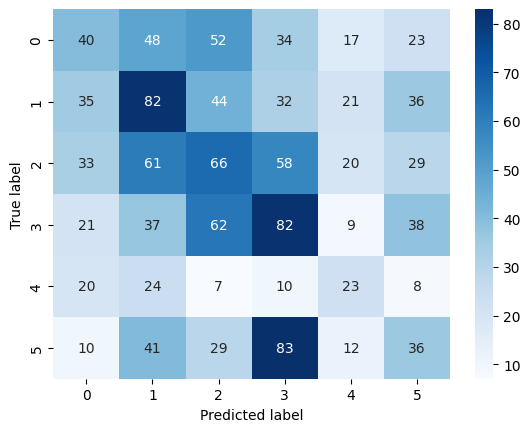

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    print(classification_report(a, y_pred))

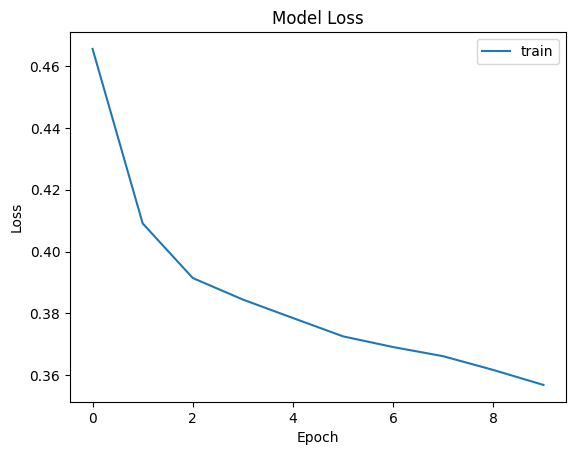

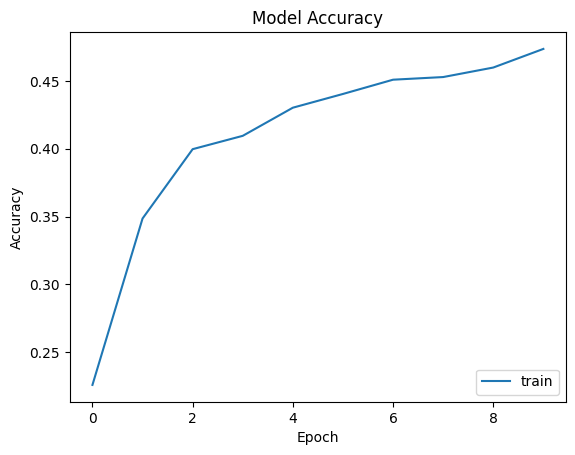

              precision    recall  f1-score   support

           0       0.19      0.14      0.16       214
           1       0.31      0.27      0.29       250
           2       0.23      0.27      0.25       267
           3       0.26      0.37      0.30       249
           4       0.32      0.20      0.24        92
           5       0.28      0.26      0.27       211

    accuracy                           0.26      1283
   macro avg       0.26      0.25      0.25      1283
weighted avg       0.26      0.26      0.25      1283



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
514/514 [==============================] - 7s 7ms/step - loss: 0.4758 - accuracy: 0.2095
Epoch 2/10
514/514 [==============================] - 2s 5ms/step - loss: 0.4157 - accuracy: 0.3193
Epoch 3/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3970 - accuracy: 0.3777
Epoch 4/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3875 - accuracy: 0.3995
Epoch 5/10
514/514 [==============================] - 3s 5ms/step - loss: 0.3812 - accuracy: 0.4090
Epoch 6/10
514/514 [==============================] - 4s 7ms/step - loss: 0.3760 - accuracy: 0.4248
Epoch 7/10
514/514 [==============================] - 3s 5ms/step - loss: 0.3713 - accuracy: 0.4418
Epoch 8/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3680 - accuracy: 0.4523
Epoch 9/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3620 - accuracy: 0.4646
Epoch 10/10
65/65 [==============================] - 0s 4ms/step - loss: 0.3641 - accuracy: 0.4489
E

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.43801822302935217
Precision: 0.44774609766785123
Loss: 0.366913640499115
Recall: 0.43801822302935217
F1-score: 0.4362382505916759


## **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(6, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
642/642 [==============================] - 15s 16ms/step - loss: 0.3731 - accuracy: 0.4319 - val_loss: 0.4371 - val_accuracy: 0.2588
Epoch 2/10
642/642 [==============================] - 9s 14ms/step - loss: 0.3554 - accuracy: 0.4724 - val_loss: 0.5829 - val_accuracy: 0.2705
Epoch 3/10
642/642 [==============================] - 9s 14ms/step - loss: 0.3476 - accuracy: 0.4863 - val_loss: 0.4772 - val_accuracy: 0.2689
Epoch 4/10
642/642 [==============================] - 9s 15ms/step - loss: 0.3402 - accuracy: 0.5002 - val_loss: 0.4718 - val_accuracy: 0.2658
Epoch 5/10
642/642 [==============================] - 8s 12ms/step - loss: 0.3313 - accuracy: 0.5174 - val_loss: 0.5043 - val_accuracy: 0.2697
Epoch 6/10
642/642 [==============================] - 10s 15ms/step - loss: 0.3195 - accuracy: 0.5397 - val_loss: 0.5406 - val_accuracy: 0.2681
Epoch 7/10
642/642 [==============================] - 9s 13ms/step - loss: 0.3044 - accuracy: 0.5722 - val_loss: 0.5387 - val_accuracy: 0.25

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 1s 7ms/step
Test Accuracy: 0.243180051445961
Test F1 Score: 0.23189432496980325
Test Recall: 0.23034128829365164
Precision: 0.24628098784751054


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

41/41 [==============================] - 0s 6ms/step
[[34 62 59 26 10 23]
 [34 88 54 23  9 42]
 [42 72 74 38  8 33]
 [30 53 67 49  4 46]
 [23 33  9  8 13  6]
 [17 53 45 38  4 54]]


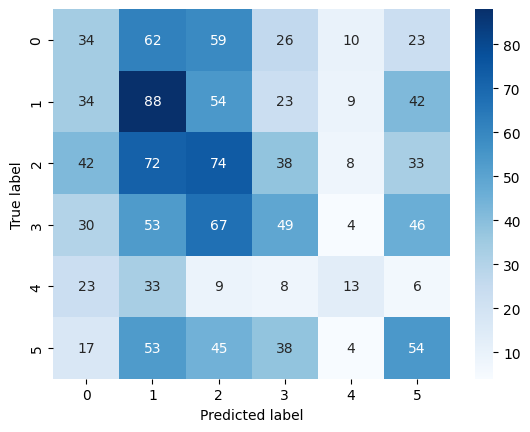

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

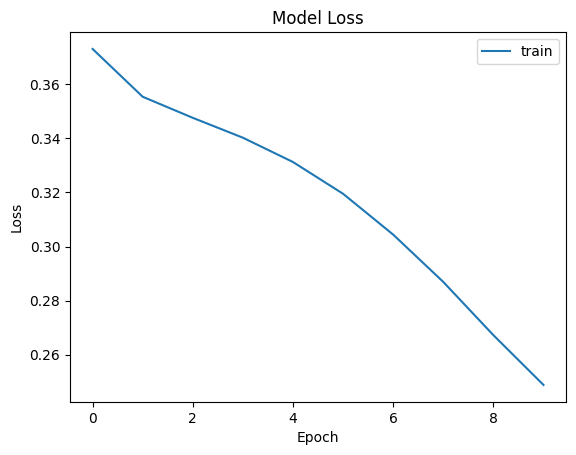

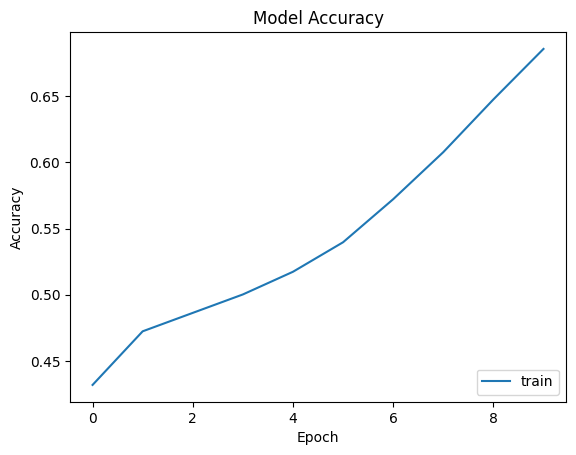

              precision    recall  f1-score   support

           0       0.19      0.16      0.17       214
           1       0.24      0.35      0.29       250
           2       0.24      0.28      0.26       267
           3       0.27      0.20      0.23       249
           4       0.27      0.14      0.19        92
           5       0.26      0.26      0.26       211

    accuracy                           0.24      1283
   macro avg       0.25      0.23      0.23      1283
weighted avg       0.24      0.24      0.24      1283



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(6, activation='softmax'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
514/514 [==============================] - 11s 11ms/step - loss: 0.3735 - accuracy: 0.4299
Epoch 2/10
514/514 [==============================] - 7s 13ms/step - loss: 0.3557 - accuracy: 0.4726
Epoch 3/10
514/514 [==============================] - 6s 12ms/step - loss: 0.3442 - accuracy: 0.4930
Epoch 4/10
514/514 [==============================] - 6s 12ms/step - loss: 0.3343 - accuracy: 0.5143
Epoch 5/10
514/514 [==============================] - 7s 13ms/step - loss: 0.3212 - accuracy: 0.5417
Epoch 6/10
514/514 [==============================] - 6s 11ms/step - loss: 0.3046 - accuracy: 0.5789
Epoch 7/10
514/514 [==============================] - 7s 14ms/step - loss: 0.2852 - accuracy: 0.6168
Epoch 8/10
514/514 [==============================] - 6s 11ms/step - loss: 0.2649 - accuracy: 0.6488
Epoch 9/10
514/514 [==============================] - 7s 14ms/step - loss: 0.2391 - accuracy: 0.6975
Epoch 10/10
65/65 [==============================] - 1s 9ms/step - loss: 0.4876 - accuracy

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.4125042270769116
Precision: 0.41796318122062515
Loss: 0.46471468210220335
Recall: 0.4125042270769116
F1-score: 0.41127254434366645


## **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(6, activation='softmax')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
642/642 [==============================] - 11s 12ms/step - loss: 0.4030 - accuracy: 0.3820 - val_loss: 0.4525 - val_accuracy: 0.2806
Epoch 2/10
642/642 [==============================] - 7s 10ms/step - loss: 0.3769 - accuracy: 0.4358 - val_loss: 0.4527 - val_accuracy: 0.2751
Epoch 3/10
642/642 [==============================] - 7s 12ms/step - loss: 0.3652 - accuracy: 0.4585 - val_loss: 0.4470 - val_accuracy: 0.2736
Epoch 4/10
642/642 [==============================] - 7s 11ms/step - loss: 0.3574 - accuracy: 0.4751 - val_loss: 0.4515 - val_accuracy: 0.2689
Epoch 5/10
642/642 [==============================] - 7s 11ms/step - loss: 0.3466 - accuracy: 0.4953 - val_loss: 0.4987 - val_accuracy: 0.2705
Epoch 6/10
642/642 [==============================] - 7s 10ms/step - loss: 0.3356 - accuracy: 0.5168 - val_loss: 0.4838 - val_accuracy: 0.2416
Epoch 7/10
642/642 [==============================] - 7s 11ms/step - loss: 0.3237 - accuracy: 0.5410 - val_loss: 0.4770 - val_accuracy: 0.265

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 5ms/step
Test Accuracy: 0.24551831185817719
Test F1 Score: 0.24196017058757666
Test Recall: 0.24208874188409213
Precision: 0.2461527940488275


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

41/41 [==============================] - 0s 5ms/step
[[33 48 51 39 16 27]
 [33 63 52 53 18 31]
 [48 40 61 73 10 35]
 [32 32 50 91  8 36]
 [17 23  6 18 22  6]
 [18 31 41 72  4 45]]


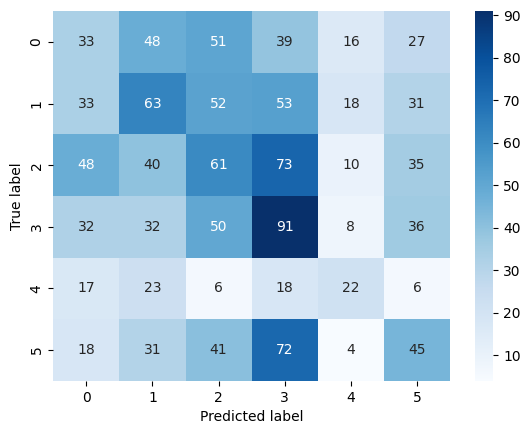

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=2)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(6, activation='softmax')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)


Epoch 1/10
514/514 [==============================] - 8s 10ms/step - loss: 0.4113 - accuracy: 0.3668
Epoch 2/10
514/514 [==============================] - 6s 11ms/step - loss: 0.3792 - accuracy: 0.4416
Epoch 3/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3705 - accuracy: 0.4512
Epoch 4/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3633 - accuracy: 0.4690
Epoch 5/10
514/514 [==============================] - 5s 11ms/step - loss: 0.3550 - accuracy: 0.4803
Epoch 6/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3449 - accuracy: 0.5051
Epoch 7/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3347 - accuracy: 0.5225
Epoch 8/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3226 - accuracy: 0.5478
Epoch 9/10
514/514 [==============================] - 5s 10ms/step - loss: 0.3127 - accuracy: 0.5643
Epoch 10/10
65/65 [==============================] - 1s 6ms/step - loss: 0.3831 - accuracy:

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.45330423428606387
Precision: 0.4585338221039398
Loss: 0.39453381299972534
Recall: 0.45330423428606387
F1-score: 0.4526833174503917


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=6, activation='softmax'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
642/642 [==============================] - 4s 4ms/step - loss: 0.3687 - accuracy: 0.4419 - val_loss: 0.4799 - val_accuracy: 0.2658
Epoch 2/10
642/642 [==============================] - 2s 4ms/step - loss: 0.3512 - accuracy: 0.4744 - val_loss: 0.4629 - val_accuracy: 0.2681
Epoch 3/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3417 - accuracy: 0.4963 - val_loss: 0.4786 - val_accuracy: 0.2790
Epoch 4/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3332 - accuracy: 0.5138 - val_loss: 0.4761 - val_accuracy: 0.2650
Epoch 5/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3241 - accuracy: 0.5271 - val_loss: 0.4966 - val_accuracy: 0.2572
Epoch 6/10
642/642 [==============================] - 2s 4ms/step - loss: 0.3151 - accuracy: 0.5449 - val_loss: 0.5172 - val_accuracy: 0.2564
Epoch 7/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3049 - accuracy: 0.5688 - val_loss: 0.5349 - val_accuracy: 0.2580
Epoch 

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.23850350081920624
Test F1 Score: 0.22173132708971266
Test Recall: 0.22110599792546148
Precision: 0.2362095679661308


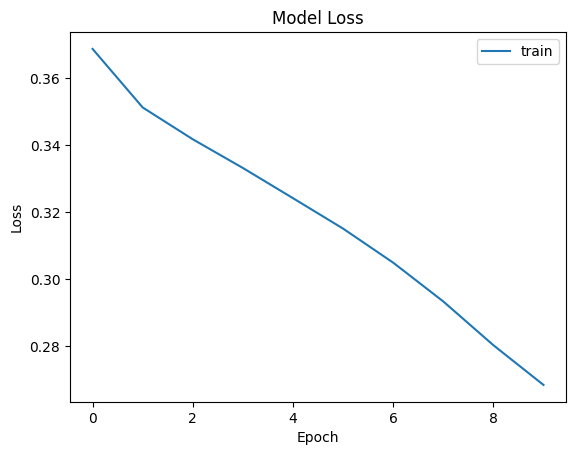

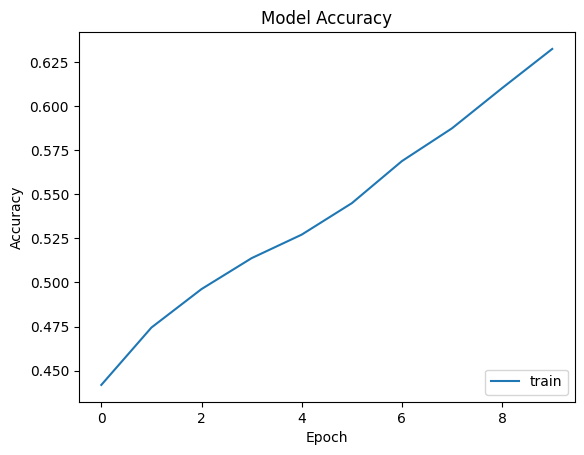

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       214
           1       0.27      0.30      0.29       250
           2       0.24      0.22      0.23       267
           3       0.25      0.34      0.29       249
           4       0.23      0.10      0.14        92
           5       0.26      0.19      0.22       211

    accuracy                           0.24      1283
   macro avg       0.24      0.22      0.22      1283
weighted avg       0.24      0.24      0.23      1283



In [ ]:
plot_history(history4,model4)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 6)                 390       
                                                                 
Total params: 784,966
Trainable params: 784,966
Non-trainable params: 0
_______________________________________________

41/41 [==============================] - 0s 2ms/step
[[37 48 51 52  9 17]
 [45 76 48 41  8 32]
 [43 63 59 71  6 25]
 [43 30 55 85  4 32]
 [21 33  7 15  9  7]
 [25 30 31 82  3 40]]


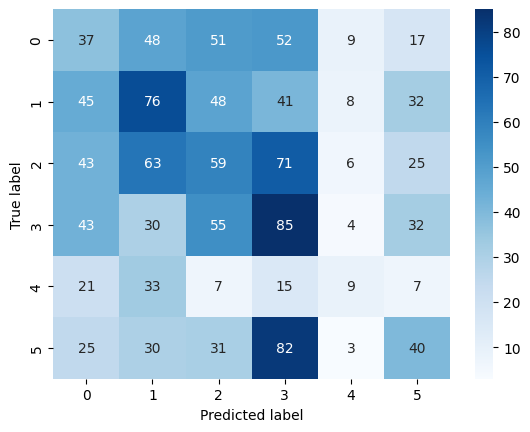

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=6, activation='softmax'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
514/514 [==============================] - 3s 4ms/step - loss: 0.3705 - accuracy: 0.4326
Epoch 2/10
514/514 [==============================] - 2s 3ms/step - loss: 0.3529 - accuracy: 0.4763
Epoch 3/10
514/514 [==============================] - 2s 3ms/step - loss: 0.3441 - accuracy: 0.4929
Epoch 4/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3352 - accuracy: 0.5092
Epoch 5/10
514/514 [==============================] - 3s 5ms/step - loss: 0.3252 - accuracy: 0.5244
Epoch 6/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3152 - accuracy: 0.5436
Epoch 7/10
514/514 [==============================] - 2s 3ms/step - loss: 0.3038 - accuracy: 0.5690
Epoch 8/10
514/514 [==============================] - 2s 3ms/step - loss: 0.2939 - accuracy: 0.5889
Epoch 9/10
514/514 [==============================] - 2s 3ms/step - loss: 0.2811 - accuracy: 0.6135
Epoch 10/10
65/65 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.4581
E

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.4408416969775155
Precision: 0.450243488219245
Loss: 0.3944909691810608
Recall: 0.4408416969775155
F1-score: 0.4353090235552064


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(6, activation='softmax'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 19s 18ms/step - loss: 0.6223 - accuracy: 0.4290
Epoch 2/10
642/642 [==============================] - 11s 17ms/step - loss: 0.3663 - accuracy: 0.4647
Epoch 3/10
642/642 [==============================] - 11s 18ms/step - loss: 0.3607 - accuracy: 0.4719
Epoch 4/10
642/642 [==============================] - 12s 18ms/step - loss: 0.3568 - accuracy: 0.4766
Epoch 5/10
642/642 [==============================] - 12s 19ms/step - loss: 0.3540 - accuracy: 0.4792
Epoch 6/10
642/642 [==============================] - 12s 18ms/step - loss: 0.3511 - accuracy: 0.4857
Epoch 7/10
642/642 [==============================] - 11s 16ms/step - loss: 0.3476 - accuracy: 0.4935
Epoch 8/10
642/642 [==============================] - 12s 18ms/step - loss: 0.3451 - accuracy: 0.5001
Epoch 9/10
642/642 [==============================] - 12s 18ms/step - loss: 0.3427 - accuracy: 0.5017
Epoch 10/10
642/642 [==============================] - 12s 18ms/step - loss: 0.339

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels)

y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 1s 9ms/step
Test Accuracy: 0.2673421800136566
Test F1 Score: 0.2656166128577832
Test Recall: 0.2636473804116582
Precision: 0.27003292656118244


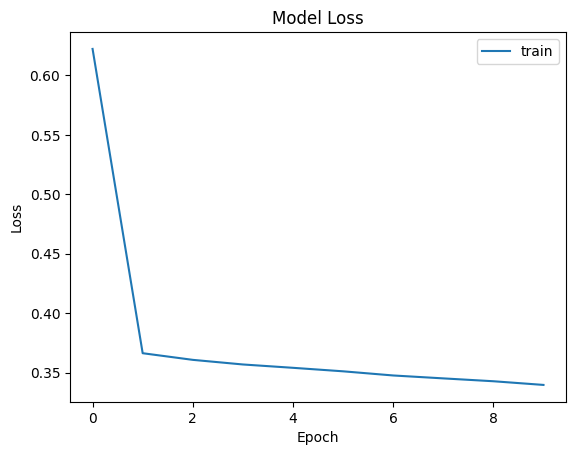

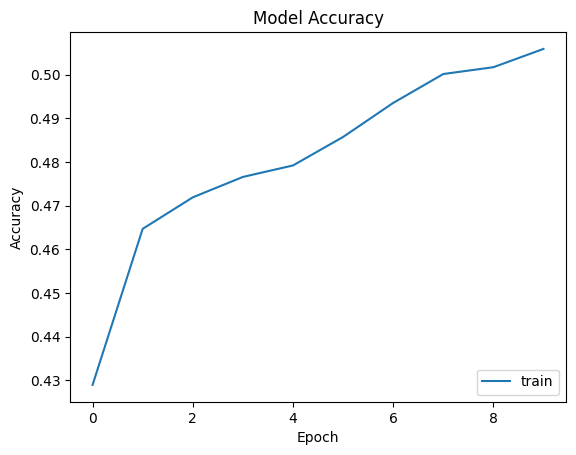

              precision    recall  f1-score   support

           0       0.24      0.26      0.25       214
           1       0.27      0.26      0.26       250
           2       0.27      0.30      0.28       267
           3       0.27      0.23      0.25       249
           4       0.29      0.23      0.26        92
           5       0.28      0.31      0.29       211

    accuracy                           0.27      1283
   macro avg       0.27      0.26      0.27      1283
weighted avg       0.27      0.27      0.27      1283



In [ ]:
plot_history(history5,model5)

In [ ]:
model5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

41/41 [==============================] - 0s 9ms/step
[[55 38 55 26 14 26]
 [48 64 50 28 16 44]
 [45 55 80 34 10 43]
 [44 27 63 58  7 50]
 [19 24  9 14 21  5]
 [19 29 40 54  4 65]]


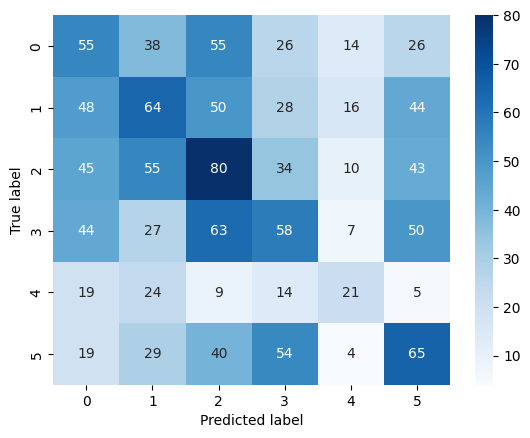

In [ ]:
y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(6, activation='softmax'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(6, activation='softmax'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

In [ ]:
plot_history(history6,model6)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(6, activation='softmax'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    # Compute the loss of the model
    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

# Dataset Binary

In [ ]:
def map_label(label):
    if (label == 'true' or label == 'mostly-true'):
        return 1
    else:
        return 0

## Train data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Train.csv'
df_train = pd.read_csv(path,delimiter=',')

In [ ]:
df_train.head()

,Label,Statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


In [ ]:
df_train['category'] = df_train['Label'].apply(map_label)
df_train['category'].unique()

array([0, 1])

In [ ]:
df_train.head()

,Label,Statement,category
0,false,Says the Annies List political group supports ...,0
1,half-true,When did the decline of coal start? It started...,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",1
3,false,Health care reform legislation is likely to ma...,0
4,half-true,The economic turnaround started at the end of ...,0


In [ ]:
df_train.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

In [ ]:
label_counts = df_train['category'].value_counts()

# Print the label distribution
print(label_counts)

0    6620
1    3649
Name: category, dtype: int64


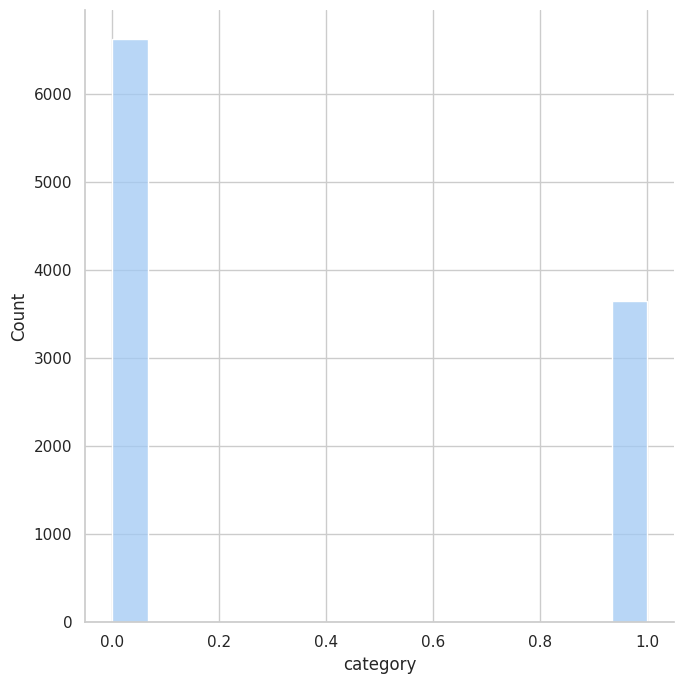

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df_train, x="category",height=7,aspect=1)

## Test data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Test.csv'
df_test = pd.read_csv(path,delimiter=',')

In [ ]:
df_test.head()

,Label,Statement
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...


In [ ]:
df_test['category'] = df_test['Label'].apply(map_label)
df_test['category'].unique()

array([1, 0])

In [ ]:
df_test.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

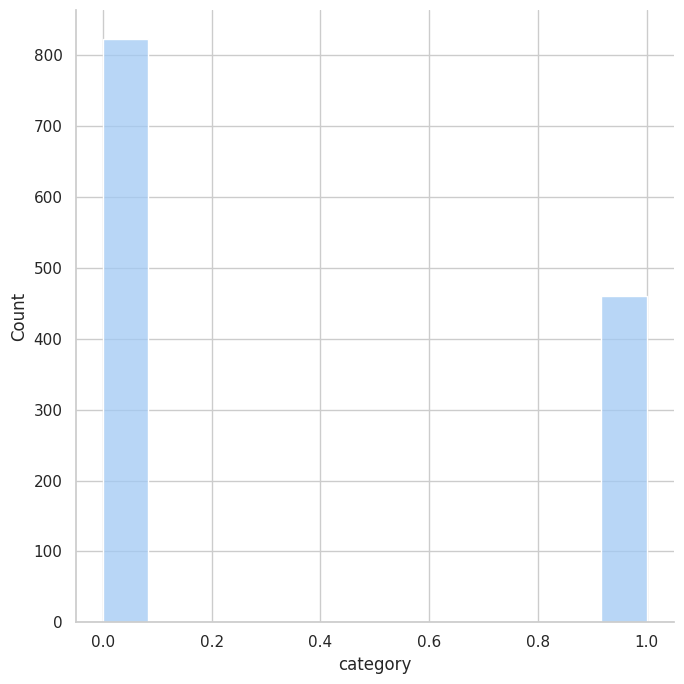

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df_test, x="category",height=7,aspect=1)

## Valid data

In [ ]:
path = '/content/drive/MyDrive/LIAR_DATASET/Valid.csv'
df_valid = pd.read_csv(path,delimiter=',')

In [ ]:
df_valid.head()

,Label,Statement
0,barely-true,We have less Americans working now than in the...
1,pants-fire,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,half-true,Says nearly half of Oregons children are poor.
4,half-true,On attacks by Republicans that various program...


In [ ]:
df_valid['category'] = df_valid['Label'].apply(map_label)
df_valid['category'].unique()

array([0, 1])

In [ ]:
df_valid.isnull().sum()

Label        0
Statement    0
category     0
dtype: int64

## DistilBERT train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

#model_distil.trainable = False
for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
df_train['Statement'] = df_train['Statement'].astype(str)
df_test['Statement'] = df_test['Statement'].astype(str)
df_valid['Statement'] = df_valid['Statement'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df_train['Statement'].tolist(), truncation = True, padding = True  )

val_encodings = tokenizer_distil(df_valid['Statement'].tolist(), truncation = True, padding = True )

test_encodings = tokenizer_distil(df_test['Statement'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df_train['category'].tolist()
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    df_valid['category'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df_test['category'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=32, epochs=2,validation_data=val_dataset)

Epoch 1/2
321/321 [==============================] - 129s 327ms/step - loss: 0.6292 - accuracy: 0.6540 - val_loss: 0.5887 - val_accuracy: 0.6916
Epoch 2/2
321/321 [==============================] - 100s 312ms/step - loss: 0.5697 - accuracy: 0.7058 - val_loss: 0.5877 - val_accuracy: 0.6869


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=32)

41/41 [==============================] - 5s 82ms/step - loss: 0.6085 - accuracy: 0.6687


## train

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_train['Statement'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 10269/10269 [19:48<00:00,  8.64it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_train['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert_bin.npy', labels)

## test

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_test['Statement'].tolist()
embeddings = []

for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_test['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert_bin.npy', labels)

## valid

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df_valid['Statement'].tolist()
embeddings = []

for i in range(0, len(titles), batch_size):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df_valid['category'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/LIAR_DATASET/embeddings_valid_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/LIAR_DATASET/labels_valid_distilbert_bin.npy', labels)

# Statements - Titles

## **CNN-DistilBERT**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_train_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_train_distilbert_bin.npy')

In [ ]:
test_embeddings = np.load('/content/drive/MyDrive/LIAR_DATASET/embeddings_test_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/LIAR_DATASET/labels_test_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([10269, 768, 1])

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels,epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 12s 8ms/step - loss: 0.5078 - accuracy: 0.7566
Epoch 2/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4554 - accuracy: 0.8014
Epoch 3/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4462 - accuracy: 0.8015
Epoch 4/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4358 - accuracy: 0.8105
Epoch 5/10
642/642 [==============================] - 5s 8ms/step - loss: 0.4289 - accuracy: 0.8103
Epoch 6/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4197 - accuracy: 0.8156
Epoch 7/10
642/642 [==============================] - 4s 5ms/step - loss: 0.4157 - accuracy: 0.8216
Epoch 8/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4044 - accuracy: 0.8234
Epoch 9/10
642/642 [==============================] - 5s 8ms/step - loss: 0.3958 - accuracy: 0.8283
Epoch 10/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3898 - accuracy: 0.834

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 3ms/step
Test Accuracy: 0.6399064660072327
Test F1 Score: 0.5053533190578159
Test Recall: 0.5130434782608696
Precision: 0.4978902953586498


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

41/41 [==============================] - 0s 3ms/step
[[585 238]
 [224 236]]


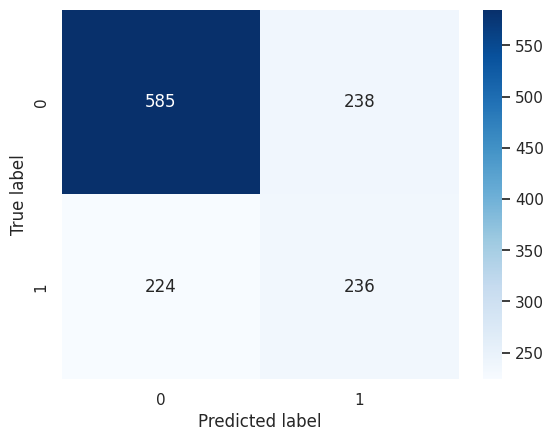

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    # Print the classification report
    print(classification_report(test_labels, y_pred))

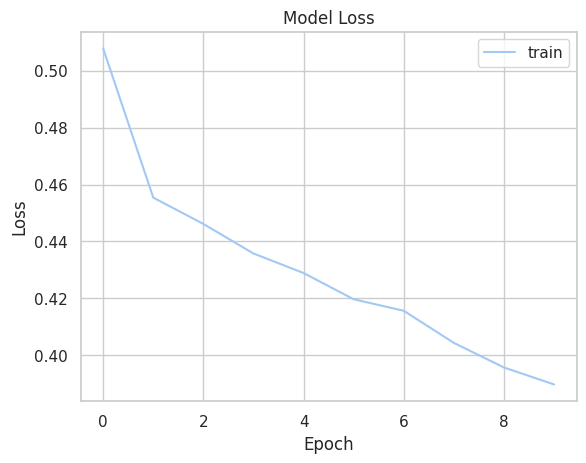

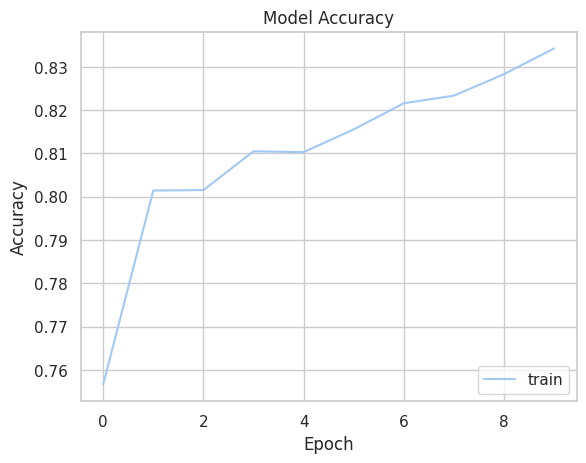

41/41 [==============================] - 0s 3ms/step


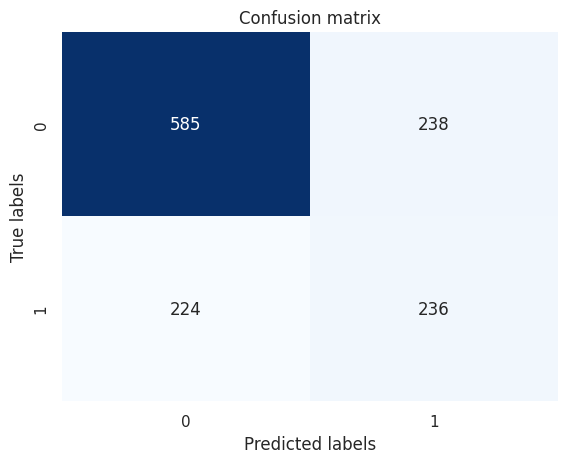

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       823
           1       0.50      0.51      0.51       460

    accuracy                           0.64      1283
   macro avg       0.61      0.61      0.61      1283
weighted avg       0.64      0.64      0.64      1283



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 5s 6ms/step - loss: 0.5136 - accuracy: 0.7430
Epoch 2/10
514/514 [==============================] - 3s 6ms/step - loss: 0.4610 - accuracy: 0.7981
Epoch 3/10
514/514 [==============================] - 4s 8ms/step - loss: 0.4518 - accuracy: 0.8004
Epoch 4/10
514/514 [==============================] - 3s 6ms/step - loss: 0.4367 - accuracy: 0.8083
Epoch 5/10
514/514 [==============================] - 3s 5ms/step - loss: 0.4277 - accuracy: 0.8105
Epoch 6/10
514/514 [==============================] - 3s 5ms/step - loss: 0.4211 - accuracy: 0.8166
Epoch 7/10
514/514 [==============================] - 3s 6ms/step - loss: 0.4098 - accuracy: 0.8205
Epoch 8/10
514/514 [==============================] - 4s 8ms/step - loss: 0.4003 - accuracy: 0.8273
Epoch 9/10
514/514 [==============================] - 3s 6ms/step - loss: 0.3894 - accuracy: 0.8335
Epoch 10/10
129/129 [==============================] - 0s 2ms/step
Epoch 1/10
514/514 [=============

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.01)
Cross-Validation Precision: 0.73 (+/- 0.03)
Cross-Validation Loss: 0.45 (+/- 0.01)
Cross-Validation Recall: 0.68 (+/- 0.10)
Cross-Validation F1 Score: 0.70 (+/- 0.04)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 15s 12ms/step - loss: 0.4637 - accuracy: 0.7873
Epoch 2/10
642/642 [==============================] - 10s 15ms/step - loss: 0.4328 - accuracy: 0.8029
Epoch 3/10
642/642 [==============================] - 8s 12ms/step - loss: 0.4198 - accuracy: 0.8109
Epoch 4/10
642/642 [==============================] - 10s 15ms/step - loss: 0.4083 - accuracy: 0.8180
Epoch 5/10
642/642 [==============================] - 9s 14ms/step - loss: 0.4022 - accuracy: 0.8216
Epoch 6/10
642/642 [==============================] - 9s 13ms/step - loss: 0.3910 - accuracy: 0.8257
Epoch 7/10
642/642 [==============================] - 10s 15ms/step - loss: 0.3802 - accuracy: 0.8291
Epoch 8/10
642/642 [==============================] - 8s 12ms/step - loss: 0.3693 - accuracy: 0.8364
Epoch 9/10
642/642 [==============================] - 10s 15ms/step - loss: 0.3545 - accuracy: 0.8457
Epoch 10/10
642/642 [==============================] - 8s 12ms/step - loss: 0.3393 - a

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

41/41 - 1s - loss: 0.7661 - accuracy: 0.6446 - 948ms/epoch - 23ms/step
41/41 [==============================] - 1s 7ms/step
Test Accuracy: 0.644582986831665
Test F1 Score: 0.5318275154004106
Test Recall: 0.5630434782608695
Precision: 0.5038910505836576


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

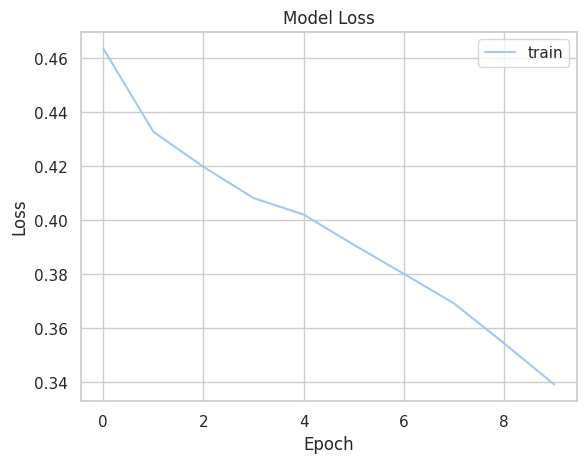

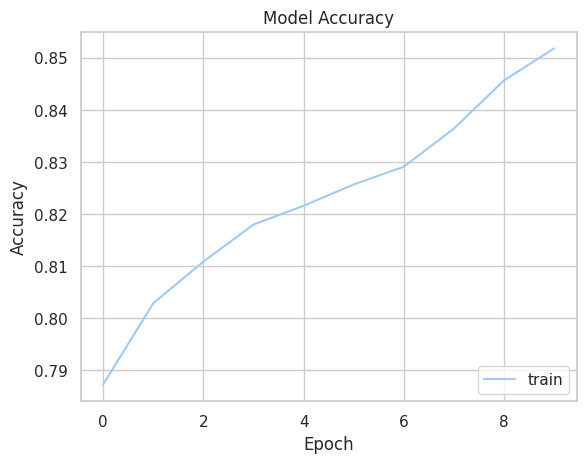

41/41 [==============================] - 0s 9ms/step


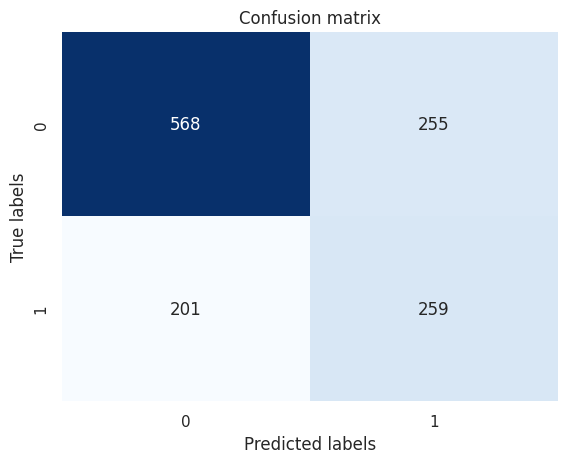

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       823
           1       0.50      0.56      0.53       460

    accuracy                           0.64      1283
   macro avg       0.62      0.63      0.62      1283
weighted avg       0.65      0.64      0.65      1283



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 12s 12ms/step - loss: 0.4625 - accuracy: 0.7890
Epoch 2/10
514/514 [==============================] - 8s 16ms/step - loss: 0.4361 - accuracy: 0.8052
Epoch 3/10
514/514 [==============================] - 6s 12ms/step - loss: 0.4224 - accuracy: 0.8079
Epoch 4/10
514/514 [==============================] - 8s 15ms/step - loss: 0.4088 - accuracy: 0.8158
Epoch 5/10
514/514 [==============================] - 6s 12ms/step - loss: 0.3989 - accuracy: 0.8240
Epoch 6/10
514/514 [==============================] - 7s 14ms/step - loss: 0.3895 - accuracy: 0.8245
Epoch 7/10
514/514 [==============================] - 7s 14ms/step - loss: 0.3740 - accuracy: 0.8358
Epoch 8/10
514/514 [==============================] - 6s 12ms/step - loss: 0.3648 - accuracy: 0.8376
Epoch 9/10
514/514 [==============================] - 8s 16ms/step - loss: 0.3452 - accuracy: 0.8521
Epoch 10/10
129/129 [==============================] - 1s 8ms/step
Epoch 1/10
514/514 [===

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.79 (+/- 0.03)
Cross-Validation Precision: 0.72 (+/- 0.09)
Cross-Validation Loss: 0.49 (+/- 0.03)
Cross-Validation Recall: 0.67 (+/- 0.09)
Cross-Validation F1 Score: 0.69 (+/- 0.03)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 10s 8ms/step - loss: 0.4866 - accuracy: 0.7727
Epoch 2/10
642/642 [==============================] - 5s 7ms/step - loss: 0.4487 - accuracy: 0.7967
Epoch 3/10
642/642 [==============================] - 6s 9ms/step - loss: 0.4378 - accuracy: 0.8036
Epoch 4/10
642/642 [==============================] - 5s 7ms/step - loss: 0.4327 - accuracy: 0.8079
Epoch 5/10
642/642 [==============================] - 5s 7ms/step - loss: 0.4231 - accuracy: 0.8144
Epoch 6/10
642/642 [==============================] - 5s 8ms/step - loss: 0.4150 - accuracy: 0.8151
Epoch 7/10
642/642 [==============================] - 5s 8ms/step - loss: 0.4070 - accuracy: 0.8189
Epoch 8/10
642/642 [==============================] - 5s 7ms/step - loss: 0.3985 - accuracy: 0.8260
Epoch 9/10
642/642 [==============================] - 5s 8ms/step - loss: 0.3917 - accuracy: 0.8278
Epoch 10/10
642/642 [==============================] - 5s 8ms/step - loss: 0.3817 - accuracy: 0.833

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

41/41 - 0s - loss: 0.7505 - accuracy: 0.6617 - 493ms/epoch - 12ms/step
41/41 [==============================] - 0s 4ms/step
Test Accuracy: 0.6617303490638733
Test F1 Score: 0.5112612612612613
Test Recall: 0.4934782608695652
Precision: 0.530373831775701


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

41/41 [==============================] - 0s 4ms/step
[[622 201]
 [233 227]]


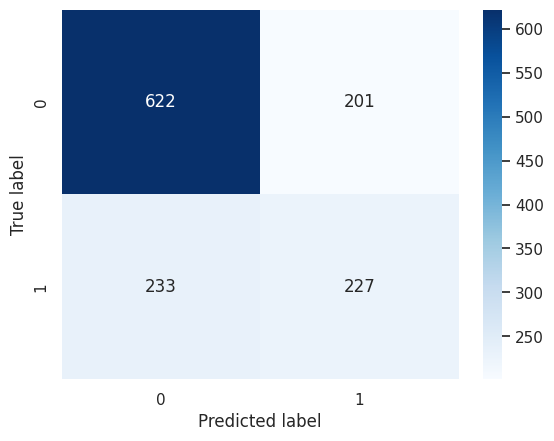

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 7s 8ms/step - loss: 0.4965 - accuracy: 0.7699
Epoch 2/10
514/514 [==============================] - 4s 9ms/step - loss: 0.4533 - accuracy: 0.7943
Epoch 3/10
514/514 [==============================] - 4s 7ms/step - loss: 0.4441 - accuracy: 0.8049
Epoch 4/10
514/514 [==============================] - 4s 7ms/step - loss: 0.4335 - accuracy: 0.8065
Epoch 5/10
514/514 [==============================] - 4s 8ms/step - loss: 0.4214 - accuracy: 0.8168
Epoch 6/10
514/514 [==============================] - 4s 8ms/step - loss: 0.4167 - accuracy: 0.8224
Epoch 7/10
514/514 [==============================] - 4s 7ms/step - loss: 0.4075 - accuracy: 0.8196
Epoch 8/10
514/514 [==============================] - 4s 7ms/step - loss: 0.3958 - accuracy: 0.8268
Epoch 9/10
514/514 [==============================] - 4s 8ms/step - loss: 0.3908 - accuracy: 0.8253
Epoch 10/10
129/129 [==============================] - 0s 3ms/step
Epoch 1/10
514/514 [=============

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.02)
Cross-Validation Precision: 0.73 (+/- 0.03)
Cross-Validation Loss: 0.45 (+/- 0.02)
Cross-Validation Recall: 0.68 (+/- 0.09)
Cross-Validation F1 Score: 0.70 (+/- 0.04)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 5s 4ms/step - loss: 0.4446 - accuracy: 0.7971
Epoch 2/10
642/642 [==============================] - 3s 4ms/step - loss: 0.4183 - accuracy: 0.8120
Epoch 3/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3997 - accuracy: 0.8240
Epoch 4/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3918 - accuracy: 0.8238
Epoch 5/10
642/642 [==============================] - 4s 6ms/step - loss: 0.3783 - accuracy: 0.8345
Epoch 6/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3683 - accuracy: 0.8394
Epoch 7/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3580 - accuracy: 0.8458
Epoch 8/10
642/642 [==============================] - 3s 4ms/step - loss: 0.3441 - accuracy: 0.8535
Epoch 9/10
642/642 [==============================] - 2s 4ms/step - loss: 0.3286 - accuracy: 0.8590
Epoch 10/10
642/642 [==============================] - 3s 5ms/step - loss: 0.3221 - accuracy: 0.8622

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.6375681757926941
Test F1 Score: 0.49180327868852464
Test Recall: 0.4891304347826087
Precision: 0.4945054945054945


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

41/41 [==============================] - 0s 2ms/step
[[593 230]
 [235 225]]


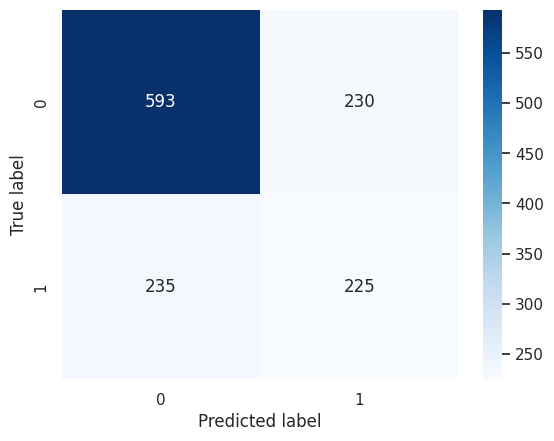

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

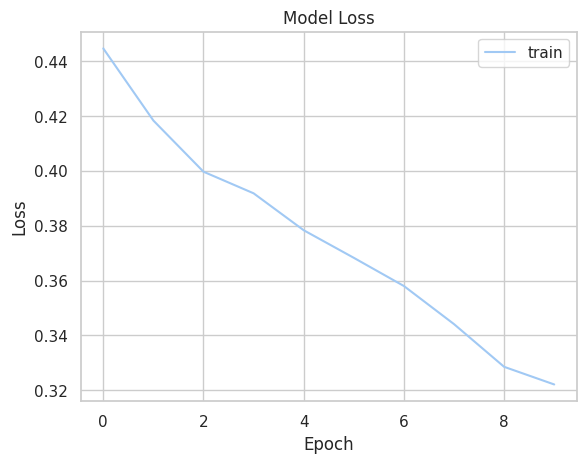

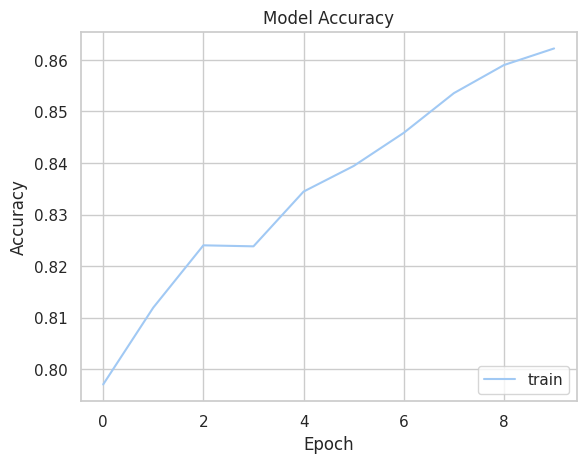

41/41 [==============================] - 0s 3ms/step


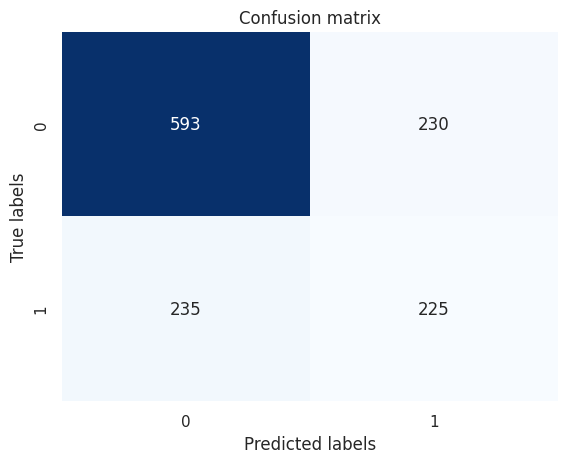

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       823
           1       0.49      0.49      0.49       460

    accuracy                           0.64      1283
   macro avg       0.61      0.60      0.61      1283
weighted avg       0.64      0.64      0.64      1283



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 3s 4ms/step - loss: 0.4488 - accuracy: 0.7939
Epoch 2/10
514/514 [==============================] - 2s 4ms/step - loss: 0.4182 - accuracy: 0.8125
Epoch 3/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3988 - accuracy: 0.8235
Epoch 4/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3843 - accuracy: 0.8306
Epoch 5/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3752 - accuracy: 0.8329
Epoch 6/10
514/514 [==============================] - 3s 6ms/step - loss: 0.3616 - accuracy: 0.8404
Epoch 7/10
514/514 [==============================] - 2s 5ms/step - loss: 0.3471 - accuracy: 0.8494
Epoch 8/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3311 - accuracy: 0.8610
Epoch 9/10
514/514 [==============================] - 2s 4ms/step - loss: 0.3187 - accuracy: 0.8650
Epoch 10/10
129/129 [==============================] - 0s 2ms/step
Epoch 1/10
514/514 [=============

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.79 (+/- 0.02)
Cross-Validation Precision: 0.77 (+/- 0.06)
Cross-Validation Loss: 0.48 (+/- 0.08)
Cross-Validation Recall: 0.61 (+/- 0.13)
Cross-Validation F1 Score: 0.67 (+/- 0.07)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 27s 18ms/step - loss: 0.8499 - accuracy: 0.7922
Epoch 2/10
642/642 [==============================] - 11s 18ms/step - loss: 0.4522 - accuracy: 0.8011
Epoch 3/10
642/642 [==============================] - 11s 17ms/step - loss: 0.4380 - accuracy: 0.8070
Epoch 4/10
642/642 [==============================] - 10s 16ms/step - loss: 0.4298 - accuracy: 0.8108
Epoch 5/10
642/642 [==============================] - 12s 19ms/step - loss: 0.4244 - accuracy: 0.8141
Epoch 6/10
642/642 [==============================] - 12s 18ms/step - loss: 0.4188 - accuracy: 0.8160
Epoch 7/10
642/642 [==============================] - 12s 18ms/step - loss: 0.4120 - accuracy: 0.8198
Epoch 8/10
642/642 [==============================] - 10s 16ms/step - loss: 0.4045 - accuracy: 0.8224
Epoch 9/10
642/642 [==============================] - 11s 18ms/step - loss: 0.4010 - accuracy: 0.8270
Epoch 10/10
642/642 [==============================] - 11s 18ms/step - loss: 0.393

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

41/41 - 2s - loss: 0.7950 - accuracy: 0.6438 - 2s/epoch - 40ms/step
41/41 [==============================] - 2s 11ms/step
Test Accuracy: 0.643803596496582
Test F1 Score: 0.5112299465240643
Test Recall: 0.5195652173913043
Precision: 0.5031578947368421


In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 382, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 378, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 189, 128)         0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                        

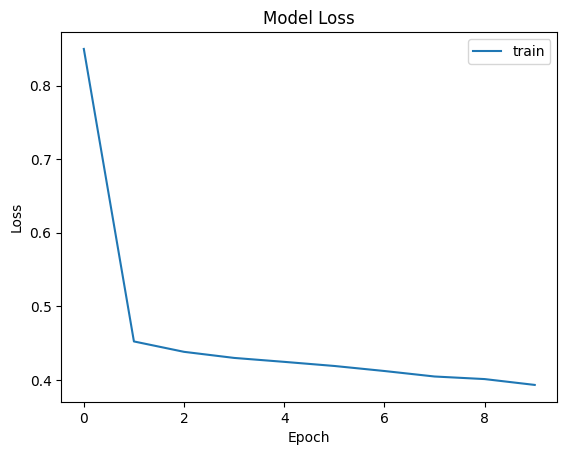

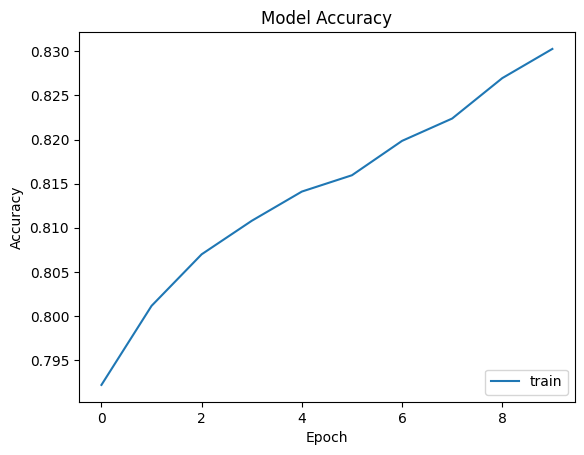

41/41 [==============================] - 1s 14ms/step


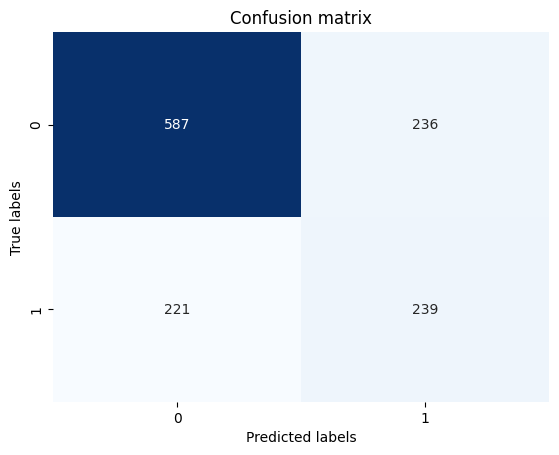

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       823
           1       0.50      0.52      0.51       460

    accuracy                           0.64      1283
   macro avg       0.61      0.62      0.62      1283
weighted avg       0.65      0.64      0.65      1283



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 16s 19ms/step - loss: 0.8870 - accuracy: 0.7834
Epoch 2/10
514/514 [==============================] - 9s 18ms/step - loss: 0.4556 - accuracy: 0.8000
Epoch 3/10
514/514 [==============================] - 9s 17ms/step - loss: 0.4421 - accuracy: 0.8046
Epoch 4/10
514/514 [==============================] - 10s 19ms/step - loss: 0.4296 - accuracy: 0.8118
Epoch 5/10
514/514 [==============================] - 15s 29ms/step - loss: 0.4219 - accuracy: 0.8155
Epoch 6/10
514/514 [==============================] - 16s 32ms/step - loss: 0.4171 - accuracy: 0.8163
Epoch 7/10
514/514 [==============================] - 10s 18ms/step - loss: 0.4089 - accuracy: 0.8197
Epoch 8/10
514/514 [==============================] - 9s 18ms/step - loss: 0.4070 - accuracy: 0.8222
Epoch 9/10
514/514 [==============================] - 10s 19ms/step - loss: 0.3990 - accuracy: 0.8265
Epoch 10/10
129/129 [==============================] - 1s 9ms/step
Epoch 1/10
514/514

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.02)
Cross-Validation Precision: 0.71 (+/- 0.05)
Cross-Validation Loss: 0.45 (+/- 0.03)
Cross-Validation Recall: 0.74 (+/- 0.10)
Cross-Validation F1 Score: 0.72 (+/- 0.02)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
642/642 [==============================] - 7s 5ms/step - loss: 0.7591 - accuracy: 0.7547
Epoch 2/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4800 - accuracy: 0.7989
Epoch 3/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4666 - accuracy: 0.8049
Epoch 4/10
642/642 [==============================] - 4s 7ms/step - loss: 0.4584 - accuracy: 0.8084
Epoch 5/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4461 - accuracy: 0.8138
Epoch 6/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4461 - accuracy: 0.8130
Epoch 7/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4375 - accuracy: 0.8228
Epoch 8/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4268 - accuracy: 0.8256
Epoch 9/10
642/642 [==============================] - 4s 6ms/step - loss: 0.4155 - accuracy: 0.8343
Epoch 10/10
642/642 [==============================] - 3s 5ms/step - loss: 0.4130 - accuracy: 0.8359

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.6461418271064758
Test F1 Score: 0.5329218106995884
Test Recall: 0.5630434782608695
Precision: 0.505859375


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 5, 128)          

41/41 [==============================] - 0s 2ms/step
[[570 253]
 [201 259]]


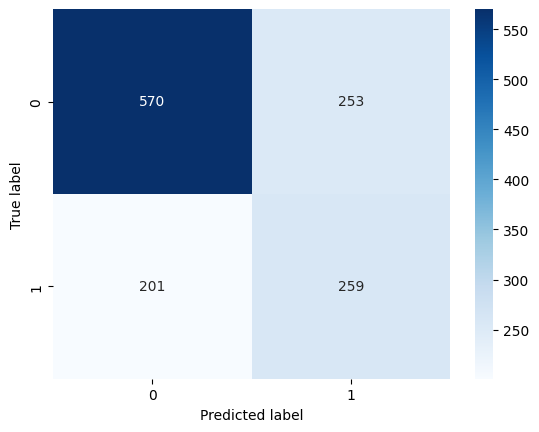

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

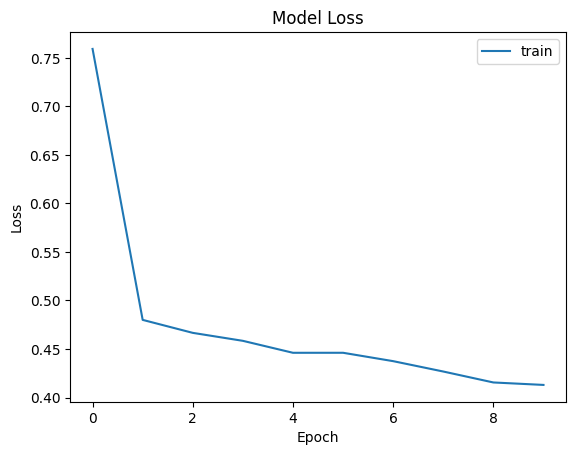

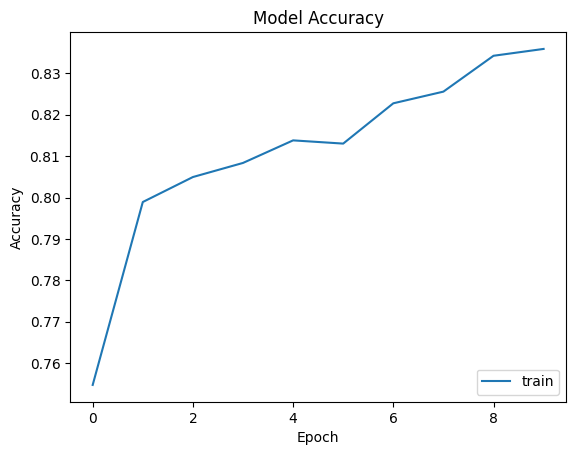

41/41 [==============================] - 0s 2ms/step


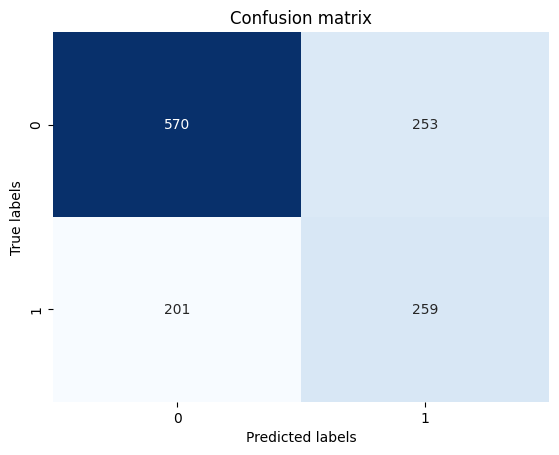

              precision    recall  f1-score   support

           0       0.74      0.69      0.72       823
           1       0.51      0.56      0.53       460

    accuracy                           0.65      1283
   macro avg       0.62      0.63      0.62      1283
weighted avg       0.66      0.65      0.65      1283



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
514/514 [==============================] - 6s 7ms/step - loss: 0.8221 - accuracy: 0.7450
Epoch 2/10
514/514 [==============================] - 3s 6ms/step - loss: 0.4893 - accuracy: 0.7938
Epoch 3/10
514/514 [==============================] - 3s 5ms/step - loss: 0.4723 - accuracy: 0.8019
Epoch 4/10
514/514 [==============================] - 3s 5ms/step - loss: 0.4644 - accuracy: 0.8056
Epoch 5/10
514/514 [==============================] - 2s 5ms/step - loss: 0.4496 - accuracy: 0.8084
Epoch 6/10
514/514 [==============================] - 3s 6ms/step - loss: 0.4475 - accuracy: 0.8150
Epoch 7/10
514/514 [==============================] - 3s 7ms/step - loss: 0.4385 - accuracy: 0.8212
Epoch 8/10
514/514 [==============================] - 2s 5ms/step - loss: 0.4339 - accuracy: 0.8258
Epoch 9/10
514/514 [==============================] - 2s 5ms/step - loss: 0.4253 - accuracy: 0.8279
Epoch 10/10
129/129 [==============================] - 0s 2ms/step
Epoch 1/10
514/514 [=============

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.80 (+/- 0.01)
Cross-Validation Precision: 0.70 (+/- 0.07)
Cross-Validation Loss: 0.44 (+/- 0.03)
Cross-Validation Recall: 0.75 (+/- 0.13)
Cross-Validation F1 Score: 0.72 (+/- 0.04)
